# An intro to some Responsible AI (RAI) issues

In this exercise, we will work with a real world dataset and explore some RAI issue around fairness and explainability.

Your goal is to femiliarize yourself with this dataset and some basic ML models in Python, both of which you will be needing through the rest of this course.

## Installing the necessary libraries

In [ ]:
  !pip install torch scikit-learn pandas folktables shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Exercise 1: Measuring fairness

In this exercise, we will work with a real world dataset and measure fairness issues.

The dataset is derived from the US Census. We will use the [folktables](https://github.com/socialfoundations/folktables/) library. folktables allows you to download different slices of the Census data. The code below is largely copied from the [folktables GitHub](https://github.com/socialfoundations/folktables/).

Let us download the employent data. The **inputs** in the dataset consist of features like age, gender, race and marital status of a person. The **label** is whether the person is employed.

Let us download the data. One can download the data for several years, and states. We will limit ourselves to 2018 and the state of Alabama.

In [ ]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["AL"], download=True)  # Limiting to AL. You can try another state or all the states.
x, y, group = ACSEmployment.df_to_numpy(acs_data)  # The group in this case is the race. It is also included in the features.

Let us have a closer look at the data.

In [ ]:
print(f"X: {x.shape}")
print(f"Y: {y.shape}")      # Predicts whether someone is employed
print(f"Group: {group.shape}")  # Race. 1 = white, 2 = black. For other values, see Appendix B4 of the paper
print(f"Features: {ACSEmployment.features}")  # See appendix B4 of the paper for details of features (https://arxiv.org/pdf/2108.04884)

X: (47777, 16)
Y: (47777,)
Group: (47777,)
Features: ['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P']


----

**The features are:**

 * AGEP (Age)
 * SCHL (Educational attainment)
 * MAR (Marital status)
 * SEX (Sex): 1 denotes Male and 2 Female
 * DIS (Disability recode): 1 denotes a disability and 2 a disability
 * ESP (Employment status of parents)
 * MIG (Mobility status (lived here 1 year ago)
 * CIT (Citizenship status)
 * MIL (Military service)
 * ANC (Ancestry recode)
 * NATIVITY (Nativity)
 * RELP (Relationship)
 * DEAR (Hearing diﬃculty)
 * DEYE (Vision diﬃculty)
 * DREM (Cognitive diﬃculty)
 * RAC1P (Recoded detailed race code): (1 means white alone, 2 means Black or African American alone)
 * GCL (Grandparents living with grandchildren)


For more details of the precise feature values, see Appendix B4 of the paper (https://arxiv.org/pdf/2108.04884)

## Exercise 1a: Inspecting the data [45 mins]

Let us get to know the data.

Start by computing the fraction of points in the positive class and the negative class. Are the classes balanced?

In [ ]:
from collections import Counter

counts = Counter(y)
counts = {k: v/len(y) for k,v in counts.items()}
print(f"Class distribution: {counts}")

Class distribution: {np.False_: 0.5902840278795236, np.True_: 0.4097159721204764}


#### Filtering the data

In this exercise, we will only be working with a subset of the data. Filter the data such that you are only left with inputs where the race is white (RAC1P=1) or black (RAC1P=2).

In [ ]:
# Your code here
acs_data = acs_data[acs_data["RAC1P"].isin([1,2])]
race_index = ACSEmployment.features.index("RAC1P")
print(race_index)
x = x[:, (race_index == 1) | (race_index == 2)]
print(x)

15
[]


#### Representation from different groups

Compute how many data points are from:
1. Each sex category (female and male)
2. Each race category (black and white)
3. Each sex/race category combination (black female, black male, white female, white male)

What kind of differences do you notice?

In [ ]:
# Your code here
print(acs_data["SEX"].value_counts())
# 1 = male, 2 = female

print(acs_data["RAC1P"].value_counts())
# 1 = white, 2 = black

print(acs_data[["SEX", "RAC1P"]].value_counts())
print(acs_data[["RAC1P", "SCHL"]])

SEX
2    23737
1    21929
Name: count, dtype: int64
RAC1P
1    35551
2    10115
Name: count, dtype: int64
SEX  RAC1P
2    1        18242
1    1        17309
2    2         5495
1    2         4620
Name: count, dtype: int64
       RAC1P  SCHL
0          1  18.0
1          2  18.0
2          1  17.0
3          1  19.0
4          1  12.0
...      ...   ...
47772      1  16.0
47773      1  11.0
47774      1   6.0
47775      1   1.0
47776      1  16.0

[45666 rows x 2 columns]


#### Feature distributions for various groups

Draw the following three histograms.

1. A histogram showing the `SCHL` feature of black and white persons.
2. A histogram showing the `SCHL` feature of female and male persons.
3. A histogram showing the `SCHL` feature of black female, black male, white female, white male persons.

Do you notice any differences?

Repeat this histogram drawing procedure for all other features.

  RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  ST   ADJINC  PWGTP  \
0  P  2018GQ0000049         6        1  1600       3   1  1013097     75   
2  P  2018GQ0000219         6        1  2000       3   1  1013097    118   
3  P  2018GQ0000246         6        1  2400       3   1  1013097     43   
4  P  2018GQ0000251         6        1  2701       3   1  1013097     16   
5  P  2018GQ0000390         6        1  2400       3   1  1013097     25   

   AGEP  ...  PWGTP71  PWGTP72  PWGTP73  PWGTP74  PWGTP75  PWGTP76  PWGTP77  \
0    19  ...      140       74       73        7       76       75       80   
2    53  ...      117      121      123      205      208      218      120   
3    28  ...       43       76       79       77       80       44       46   
4    25  ...        4        2       29       17       15       28       17   
5    30  ...       28       28        1       26       47       25        3   

   PWGTP78  PWGTP79  PWGTP80  
0       74        7       72  
2     

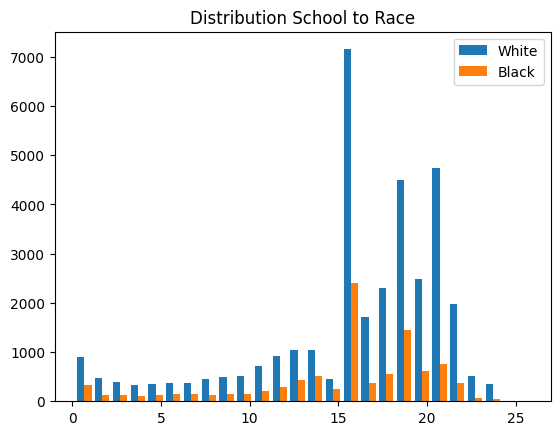

In [ ]:
# Your code here
import numpy as np
bins = np.arange(0.5, 25.5 + 1)
print(acs_data[acs_data["RAC1P"] == 1].head())
import matplotlib.pyplot as plt
plt.title("Distribution School to Race")
white_school = acs_data[acs_data["RAC1P"] == 1]["SCHL"]
plt.hist(white_school, bins=bins - 0.2, width=0.4, label="White")
black_school = acs_data[acs_data["RAC1P"] == 2]["SCHL"]
plt.hist(black_school, bins=bins + 0.2, width=0.4, label="Black")
plt.legend()

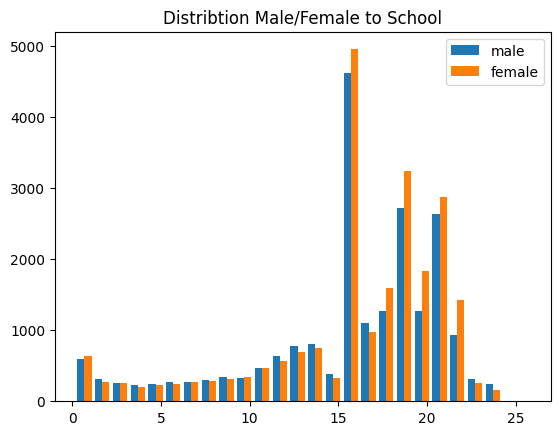

In [ ]:
import matplotlib.pyplot as plt
plt.title("Distribtion Male/Female to School")
male_school = acs_data[acs_data["SEX"] == 1]["SCHL"]
plt.hist(male_school, bins=bins - 0.2, width=0.4, label="male")
female_school = acs_data[acs_data["SEX"] == 2]["SCHL"]
plt.hist(female_school, bins=bins + 0.2, width=0.4, label="female")
plt.legend()


(array([ 447.,  255.,  197.,  177.,  196.,  199.,  188.,  230.,  262.,
         269.,  352.,  471.,  552.,  538.,  258., 3404.,  904., 1039.,
        2125., 1055., 2360.,  822.,  291.,  221.,    0.]),
 array([ 0.75,  1.75,  2.75,  3.75,  4.75,  5.75,  6.75,  7.75,  8.75,
         9.75, 10.75, 11.75, 12.75, 13.75, 14.75, 15.75, 16.75, 17.75,
        18.75, 19.75, 20.75, 21.75, 22.75, 23.75, 24.75, 25.75]),
 <BarContainer object of 25 artists>)

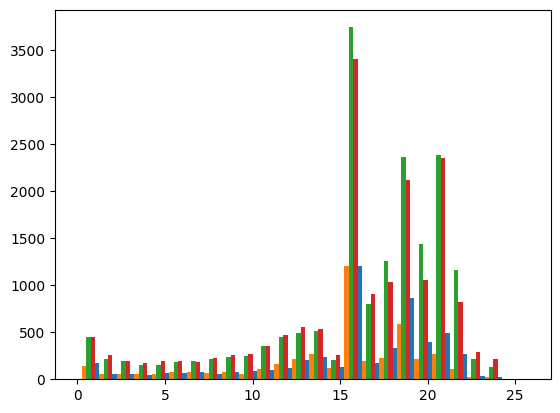

In [ ]:
# prompt: same as previous now with black_female, black_male, white_female, white_male

black_female = acs_data[(acs_data["RAC1P"] == 2) & (acs_data["SEX"] == 2)]["SCHL"]
black_male = acs_data[(acs_data["RAC1P"] == 2) & (acs_data["SEX"] == 1)]["SCHL"]
white_female = acs_data[(acs_data["RAC1P"] == 1) & (acs_data["SEX"] == 2)]["SCHL"]
white_male = acs_data[(acs_data["RAC1P"] == 1) & (acs_data["SEX"] == 1)]["SCHL"]


bins = np.arange(0.5, 25.5 + 1)
plt.hist(black_female, bins=bins-0.5, width=0.25, label="black femal")
plt.hist(black_male, bins=bins-0.25, width=0.25)
plt.hist(white_female, bins=bins, width=0.25)
plt.hist(white_male, bins=bins+0.25, width=0.25)




#### Class distributions for various groups

Compute the following probabilities from the training data:

1. P(y=employed | sex = female) and P(y=employed | sex = female)
2. P(y=employed | race = white) and P(y=employed | race = black)
3. P(y=employed | groups = z) where z can be black female, black male, white female and white male.

In [ ]:
# Your code here


## Exercise 1b: Training classifiers and measuring unfairness [15 mins]

Split the data into train and test sets. Train a LogisticRegression classifier on the data. For both sex and race, compute the predicted class distribution. That is, repeat the class distribution procedure from the previous exercise, but use the predicted labels instead of the ground truth labels. Do you see any differences?


You can use [LogisticRegression](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) class from sklearn.

Inspect the weight vector `w` of the model. You can obtain this vector by calling `model.coef_`.

In [ ]:
# Your code here
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
train_df, test_df = train_test_split(acs_data, test_size=0.2, random_state=42)
train_x, train_y, train_group = ACSEmployment.df_to_numpy(train_df)
test_x, test_y, test_group = ACSEmployment.df_to_numpy(test_df)


array([[42., 18.,  1., ...,  2.,  1.,  2.],
       [33., 22.,  1., ...,  2.,  1.,  1.],
       [74., 16.,  1., ...,  2.,  1.,  1.],
       ...,
       [32., 20.,  1., ...,  2.,  1.,  1.],
       [22., 19.,  5., ...,  2.,  1.,  2.],
       [68., 19.,  1., ...,  2.,  1.,  1.]])

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(train_x, train_y)

LogisticRegression(max_iter=1000)

In [ ]:
model.predict(test_x)

array([False, False,  True, ..., False,  True,  True])

# Exercise 2: Explaining the model decisions

One way to explain model decisions is to check which features the model found most important.

There are method like [SHAP](https://github.com/shap/shap) that, given an input instance, help you find the most important features. On the GitHub page, locate the KernelExplainer method. Given a set of data points, the method uses the following API:

``` python
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)
```

## Exercise 2a: KernelSHAP explanations for the Logistic Regression Model [20 mins]

Select a random input instance. Get the feature importance scores using KernelSHAP. List the features in the order of their importance.

In [ ]:
# Your code here
import shap
explainer = shap.KernelExplainer(model.predict, train_x[:1000], link="logit")
shap_values = explainer.shap_values(test_x, nsamples=100)

  0%|          | 0/9134 [00:00<?, ?it/s]

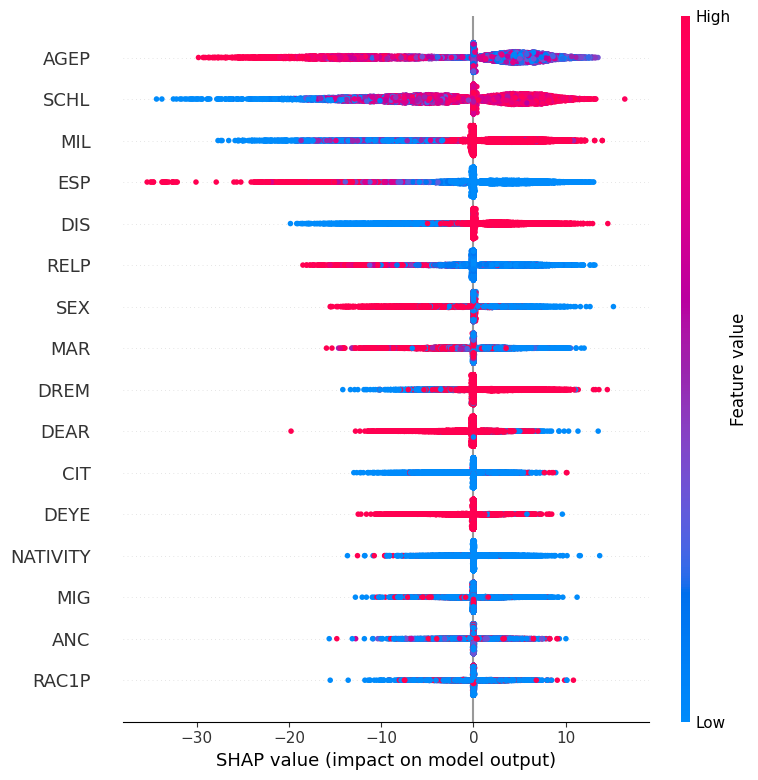

In [ ]:
# shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, test_x, feature_names=ACSEmployment.features)

## Exercise 2b: KernelSHAP explanations for a Neural Network [15 mins]

Train a Neural Network models with two hidden layers of 128 units each. You can use the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) from the sklearn library.

Get the KernelSHAP feature importance scores for the Neural Network. Do you see any differences?

In [ ]:
# Your code here

In [ ]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300, verbose=True)
classifier.fit(train_x, train_y)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=300)

In [ ]:
classifier_explainer = shap.KernelExplainer(classifier.predict, train_x[:100], link="logit")
classifier_shap_values = classifier_explainer.shap_values(test_x[:100], nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
classifier_shap_values

array([ -8.5829447 , -10.19118616,   0.        , -14.71949317,
         0.        ,  -1.41179131,   2.82942115,   0.        ,
         0.        ,  -1.63543538,   6.63184926,  -3.73220408,
        -1.98263436,  -1.62421334,   0.        ,   0.        ])

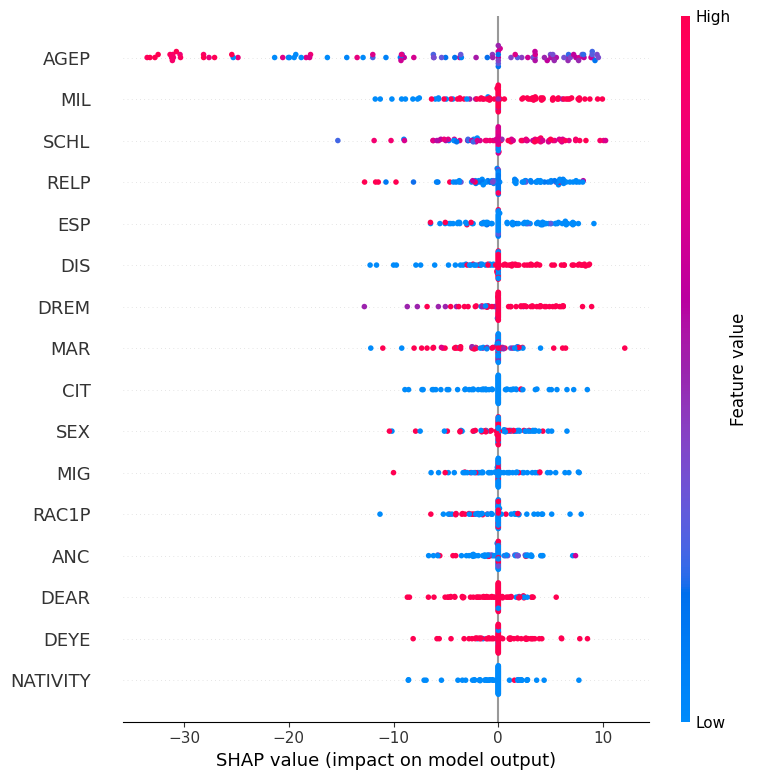

In [ ]:
shap.summary_plot(classifier_shap_values, test_x[:100], feature_names=ACSEmployment.features)

Python 3.11.12
